In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random

In [2]:
random.seed(3888)

In [32]:
df = pd.read_csv("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/individual_book_train/stock_0.csv")

In [33]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:
    # 1. mid_price & spread
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['spread']    = df['ask_price1'] - df['bid_price1']
    
    # 2. imbalance & book_pressure & microprice, shielding their denominators
    with np.errstate(divide='ignore', invalid='ignore'):
        # Level-1 imbalance
        num  = df['bid_size1'] - df['ask_size1']
        den  = df['bid_size1'] + df['ask_size1']
        df['imbalance'] = np.where(den>0, num/den, np.nan)
        
        # Book pressure (L1+L2)
        num2 = (df['bid_size1'] + df['bid_size2']) - (df['ask_size1'] + df['ask_size2'])
        den2 = df[['bid_size1','bid_size2','ask_size1','ask_size2']].sum(axis=1)
        df['book_pressure'] = np.where(den2>0, num2/den2, np.nan)
        
        # Microprice
        num3 = (df['ask_price1'] * df['bid_size1'] +
                df['bid_price1'] * df['ask_size1'])
        df['microprice'] = np.where(den>0, num3/den, np.nan)
    
    # 3. normalized_spread & L2 order‐book imbalance
    df['normalized_spread'] = df['spread'] / df['mid_price'].replace(0, np.nan)
    df['OBI_L2'] = np.where(
        den2>0,
        (df['bid_size1'] + df['bid_size2']) / den2,
        np.nan
    )
    
    # 4. entropy of the LOB
    sizes = df[['bid_size1','bid_size2','ask_size1','ask_size2']].astype(float).values
    total = sizes.sum(axis=1, keepdims=True)
    p     = np.divide(sizes, total, where=total!=0)
    entropy = -np.nansum(np.where(p>0, p*np.log(p), 0), axis=1)
    df['LOB_entropy']            = entropy
    df['LOB_entropy_normalized'] = entropy / np.log(4)
    
    # 5. log returns
    df['log_return'] = (
        df.groupby('time_id')['mid_price']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 5a. realized_volatility over past-30 ticks (no leakage)
    df['realized_volatility'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: 
              np.sqrt((x.shift(1)**2)           # <-- shift here
                       .rolling(window=30, min_periods=1) # window size
                       .sum())
          )
    )

    # 5b. bipower variance over past-30 ticks
    df['bipower_var'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: 
              x.abs()
               .shift(1)                        # only prior returns
               .rolling(2, min_periods=1)
               .apply(lambda r: r[0]*r[1], raw=True)
               .rolling(30, min_periods=1) # window size
               .mean()
          )
    )

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df.dropna()
df = make_features(df)

In [4]:
volatility = df['realized_volatility'].values.reshape(-1, 1)
scaler = MinMaxScaler()
volatility_scaled = scaler.fit_transform(volatility).flatten()
SEQ_LEN = 30
def create_dataset(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X)[..., np.newaxis], np.array(y)

X, y = create_dataset(volatility_scaled, SEQ_LEN)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [5]:
input_dim = X_train.shape[1]
input_layer = keras.Input(shape=(input_dim,), name="input")

x = layers.Dense(32, activation='relu')(input_layer)
x = layers.Dense(16, activation='relu', name="bottleneck")(x)  
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='linear')(x)

# Build & compile
model = keras.Model(inputs=input_layer, outputs=output_layer, name="supervised_bottleneck")
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "supervised_bottleneck"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,097 (8.19 KB)

 Trainable params: 2,097 (8.19 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,      
    batch_size=256, 
    verbose=1
)

Epoch 1/10
129032/129032 ━━━━━━━━━━━━━━━━━━━━ 52s 396us/step - loss: 7.7440e-06 - val_loss: 8.6988e-06
Epoch 2/10
129032/129032 ━━━━━━━━━━━━━━━━━━━━ 50s 381us/step - loss: 6.2066e-06 - val_loss: 8.2937e-06
Epoch 3/10
129032/129032 ━━━━━━━━━━━━━━━━━━━━ 49s 377us/step - loss: 5.6510e-06 - val_loss: 8.0468e-06
Epoch 4/10
129032/129032 ━━━━━━━━━━━━━━━━━━━━ 49s 375us/step - loss: 5.6002e-06 - val_loss: 8.5269e-06
Epoch 5/10
129032/129032 ━━━━━━━━━━━━━━━━━━━━ 49s 375us/step - loss: 5.7997e-06 - val_loss: 8.0769e-06
Epoch 6/10
129032/129032 ━━━━━━━━━━━━━━━━━━━━ 49s 378us/step - loss: 5.3624e-06 - val_loss: 7.9143e-06
Epoch 7/10
129032/129032 ━━━━━━━━━━━━━━━━━━━━ 50s 379us/step - loss: 5.4676e-06 - val_loss: 7.6799e-06
Epoch 8/10
129032/129032 ━━━━━━━━━━━━━━━━━━━━ 49s 378us/step - loss: 5.4354e-06 - val_loss: 7.7566e-06
Epoch 9/10
129032/129032 ━━━━━━━━━━━━━━━━━━━━ 50s 381us/step - loss: 5.3367e-06 - val_loss: 7.8690e-06
Epoch 10/10
129032/129032 ━━━━━━━━━━━━━━━━━━━━ 50s 381us/step - loss: 5.3

In [7]:
bottleneck_extractor = keras.Model(
    inputs=model.input,
    outputs=model.get_layer("bottleneck").output
)

X_train_encoded = bottleneck_extractor.predict(X_train)
X_test_encoded  = bottleneck_extractor.predict(X_test)

1032250/1032250 ━━━━━━━━━━━━━━━━━━━━ 159s 154us/step
258063/258063 ━━━━━━━━━━━━━━━━━━━━ 40s 154us/step


In [8]:
mlp_input_dim = X_train_encoded.shape[1]

mlp_input = keras.Input(shape=(mlp_input_dim,), name="mlp_input")
x = layers.Dense(32, activation='relu')(mlp_input)
x = layers.Dense(16, activation='relu')(x)
mlp_output = layers.Dense(1, activation='linear')(x)

regressor = keras.Model(inputs=mlp_input, outputs=mlp_output, name="regressor")
regressor.compile(optimizer='adam', loss='mse')  

regressor.summary()

history_mlp = regressor.fit(
    X_train_encoded, y_train,
    validation_data=(X_test_encoded, y_test),
    epochs=10,            
    batch_size=256,      
    verbose=1
)

Model: "regressor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mlp_input (InputLayer)          │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,089 (4.25 KB)

 Trainable params: 1,089 (4.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
129032/129032 ━━━━━━━━━━━━━━━━━━━━ 45s 340us/step - loss: 6.9895e-06 - val_loss: 7.4623e-06
Epoch 2/10
129032/129032 ━━━━━━━━━━━━━━━━━━━━ 44s 338us/step - loss: 5.2005e-06 - val_loss: 7.4548e-06
Epoch 3/10
129032/129032 ━━━━━━━━━━━━━━━━━━━━ 45s 345us/step - loss: 5.2174e-06 - val_loss: 7.5410e-06
Epoch 4/10
129032/129032 ━━━━━━━━━━━━━━━━━━━━ 44s 336us/step - loss: 5.1352e-06 - val_loss: 7.5333e-06
Epoch 5/10
129032/129032 ━━━━━━━━━━━━━━━━━━━━ 44s 337us/step - loss: 5.0697e-06 - val_loss: 7.5004e-06
Epoch 6/10
129032/129032 ━━━━━━━━━━━━━━━━━━━━ 44s 338us/step - loss: 5.1656e-06 - val_loss: 7.4557e-06
Epoch 7/10
129032/129032 ━━━━━━━━━━━━━━━━━━━━ 44s 338us/step - loss: 5.1429e-06 - val_loss: 7.4280e-06
Epoch 8/10
129032/129032 ━━━━━━━━━━━━━━━━━━━━ 44s 336us/step - loss: 5.1459e-06 - val_loss: 7.4748e-06
Epoch 9/10
129032/129032 ━━━━━━━━━━━━━━━━━━━━ 44s 339us/step - loss: 5.1892e-06 - val_loss: 7.5142e-06
Epoch 10/10
129032/129032 ━━━━━━━━━━━━━━━━━━━━ 44s 338us/step - loss: 5.1

In [9]:
y_pred = regressor.predict(X_test_encoded)
mse  = mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"MLP on Autoencoder Encoded Features - MSE: {mse:.4f}  R^2: {r2:.4f}")

258063/258063 ━━━━━━━━━━━━━━━━━━━━ 40s 156us/step
MLP on Autoencoder Encoded Features - MSE: 0.0000  R^2: 0.9700


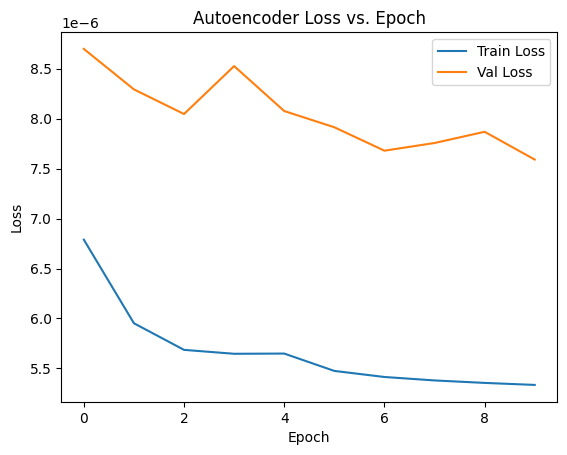

In [10]:
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Autoencoder Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

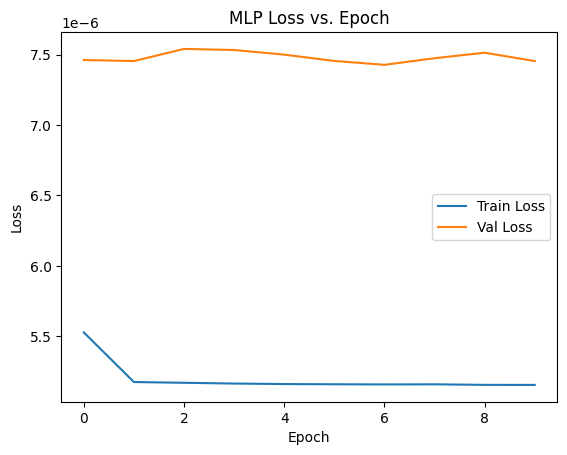

In [11]:
plt.figure()
plt.plot(history_mlp.history['loss'], label='Train Loss')
plt.plot(history_mlp.history['val_loss'], label='Val Loss')
plt.title('MLP Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

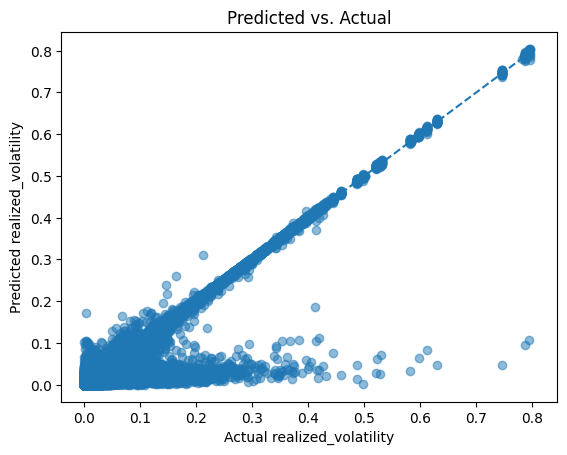

In [12]:
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual realized_volatility')
plt.ylabel('Predicted realized_volatility')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.show()

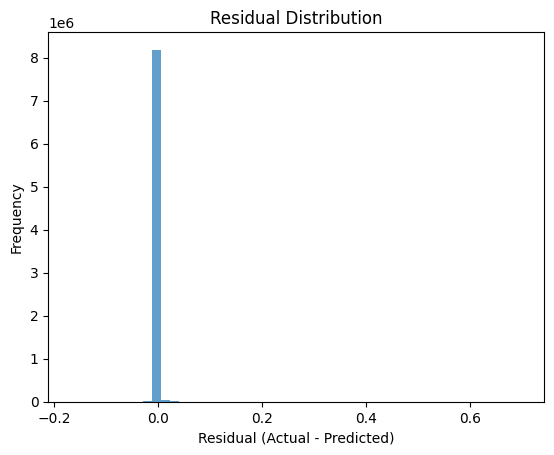

In [13]:
residuals = y_test - y_pred.flatten()

plt.figure()
plt.hist(residuals, bins=50, alpha=0.7)
plt.title('Residual Distribution')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()